# Model Definition and Evaluation
## Table of Contents
1. [Model Selection](#model-selection)
2. [Feature Engineering](#feature-engineering)
3. [Hyperparameter Tuning](#hyperparameter-tuning)
4. [Implementation](#implementation)
5. [Evaluation Metrics](#evaluation-metrics)
6. [Comparative Analysis](#comparative-analysis)


In [2]:
!pip install xgboost

   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   - -------------------------------------- 5.2/124.9 MB 29.0 MB/s eta 0:00:05
   ----- ---------------------------------- 17.8/124.9 MB 45.0 MB/s eta 0:00:03
   -------- ------------------------------- 25.4/124.9 MB 41.3 MB/s eta 0:00:03
   ---------- ----------------------------- 31.5/124.9 MB 38.4 MB/s eta 0:00:03
   ------------ --------------------------- 37.5/124.9 MB 36.7 MB/s eta 0:00:03
   -------------- ------------------------- 44.0/124.9 MB 35.5 MB/s eta 0:00:03
   ---------------- ----------------------- 50.6/124.9 MB 34.6 MB/s eta 0:00:03
   ------------------ --------------------- 57.1/124.9 MB 34.0 MB/s eta 0:00:02
   -------------------- ------------------- 64.0/124.9 MB 34.0 MB/s eta 0:00:02
   ---------------------- ----------------- 70.8/124.9 MB 33.7 MB/s eta 0:00:02
   ------------------------ --------------- 77.9/124.9 MB 33.8 MB/s eta 0:00:02
   --------------------------- ------------ 85.5/1

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb  # Add XGBoost import
import matplotlib.pyplot as plt

## Model Selection

# Random Forest Regressor is chosen for this task because:
# 1. It handles non-linear relationships well
# 2. Provides feature importance rankings
# 3. Less prone to overfitting due to ensemble nature
# 4. Works well with numerical time series data



## Feature Engineering

[Describe any additional feature engineering you've performed beyond what was done for the baseline model.]


In [4]:
# Load data and show a few rows to verify
df = pd.read_csv('D:/DEV/ATSMCourse/AdvancedTimeSeriesCourse-Engineering-Data-main/Data/train_p27_no_gaps.csv')
df['time'] = pd.to_datetime(df['time'])
df['target'] = df.groupby('subj')['glucose_imp'].shift(-12)

# Verify shift
print("Verification of 1-hour prediction setup:")
sample = df[['time', 'glucose_imp', 'target']].head(15)
print("\nFirst few rows:")
print(sample)

print("\nDetailed example of one prediction setup:")
current_time = df['time'].iloc[0]
current_glucose = df['glucose_imp'].iloc[0]
future_glucose = df['target'].iloc[0]
future_time = df['time'].iloc[12]
print(f"Features from: {current_time}, glucose_imp = {current_glucose}")
print(f"Predicting  : {future_time}, target = {future_glucose}")

# Transform Time-Based-Features
df['hour'] = df['time'].dt.hour
df['day'] = df['time'].dt.day
df['month'] = df['time'].dt.month
df['day_of_week'] = df['time'].dt.dayofweek

# Convert categorical 'subj' column to numeric using one-hot encoding
subject_dummies = pd.get_dummies(df['subj'], prefix='subject')
df = pd.concat([df, subject_dummies], axis=1)

columns_to_drop = ['time', 'old_time', 'subj', 'glucose']  # dropping original glucose, keeping glucose_imp
df = df.drop(columns_to_drop, axis=1)
df = df.dropna(subset=['target'])

# Prepare features and target
feature_columns = [col for col in df.columns if col not in ['target']]
X = df[feature_columns]
y = df['target']

# Print first 5 rows of final dataset
print("\nFirst 5 rows of processed dataset:")
print(df.head())


Verification of 1-hour prediction setup:

First few rows:
                  time  glucose_imp      target
0  2020-06-26 22:15:00   112.000000  112.000000
1  2020-06-26 22:20:00   105.000000  114.000000
2  2020-06-26 22:25:00    98.000000  116.000000
3  2020-06-26 22:30:00    91.000000  118.000000
4  2020-06-26 22:35:00    91.000000  117.666667
5  2020-06-26 22:40:00    91.000000  117.333333
6  2020-06-26 22:45:00    91.000000  117.000000
7  2020-06-26 22:50:00    94.333333  116.666667
8  2020-06-26 22:55:00    97.666667  116.333333
9  2020-06-26 23:00:00   101.000000  116.000000
10 2020-06-26 23:05:00   104.666667  117.000000
11 2020-06-26 23:10:00   108.333333  118.000000
12 2020-06-26 23:15:00   112.000000  119.000000
13 2020-06-26 23:20:00   114.000000  121.333333
14 2020-06-26 23:25:00   116.000000  123.666667

Detailed example of one prediction setup:
Features from: 2020-06-26 22:15:00, glucose_imp = 112.0
Predicting  : 2020-06-26 23:15:00, target = 112.0

First 5 rows of processe

## Hyperparameter Tuning

[Discuss any hyperparameter tuning methods you've applied, such as Grid Search or Random Search, and the rationale behind them.]


In [12]:
# Define parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200], 
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Grid Search
rf_model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X, y)

print("\nBest parameters:", grid_search.best_params_)
print("Best MSE:", -grid_search.best_score_)






Best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best MSE: 34.15376060831688


## Implementation

[Implement the final model(s) you've selected based on the above steps.]


In [6]:
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)

# Define parameter grid for XGBoost
param_grid = {
    'n_estimators': [100, 200], 
    'max_depth': [10, 20],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Perform Grid Search
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=2,
    n_jobs=-1
)
# Fit the model
grid_search.fit(X, y)

# Get the best model
final_model = grid_search.best_estimator_

print("Best parameters:", grid_search.best_params_)
print("Best score:", np.sqrt(-grid_search.best_score_))


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters: {'colsample_bytree': 1.0, 'max_depth': 10, 'n_estimators': 100, 'subsample': 0.8}
Best score: 29.842542918683996


## Evaluation Metrics

[Clearly specify which metrics you'll use to evaluate the model performance, and why you've chosen these metrics.]



Model Performance (Rolling Window 1-hour-ahead predictions):
Root Mean Squared Error (RMSE): 22.96
Mean Absolute Percentage Error (MAPE): 15.69%


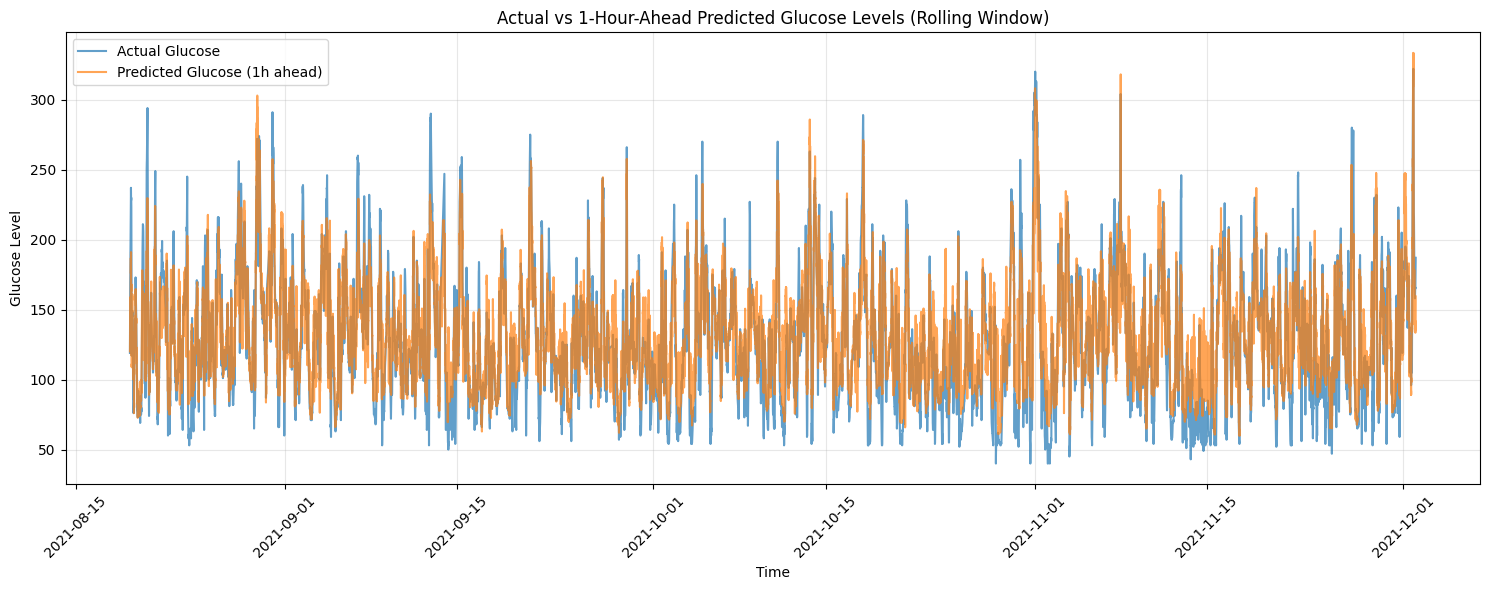

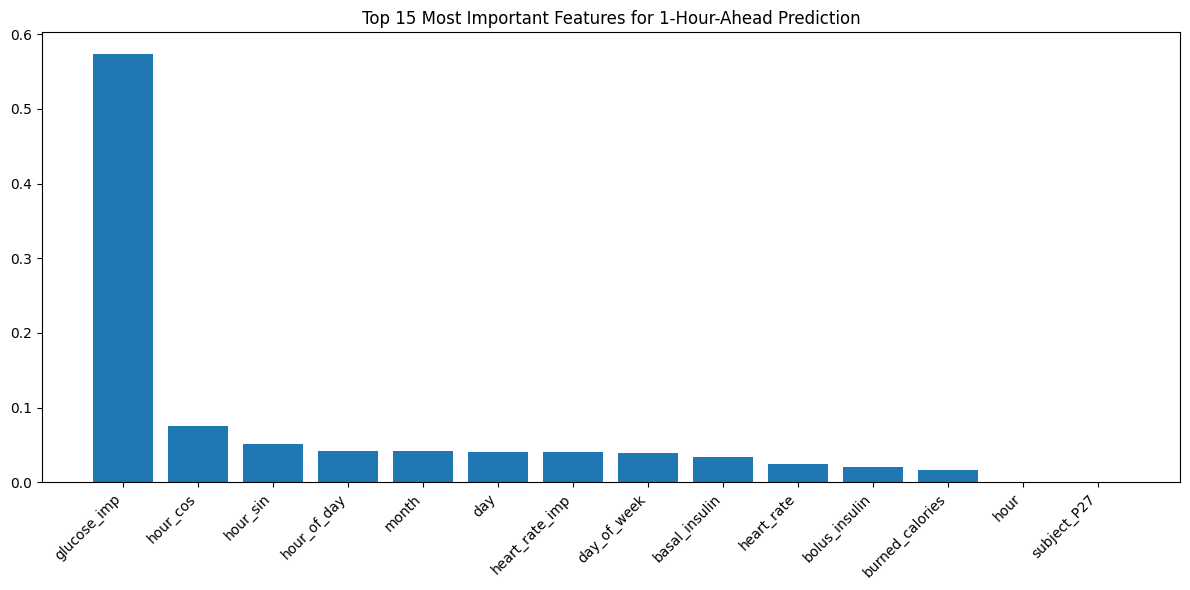

In [7]:
test_df = pd.read_csv('D:/DEV/ATSMCourse/AdvancedTimeSeriesCourse-Engineering-Data-main/Data/test_p27_no_gaps.csv')
test_df['time'] = pd.to_datetime(test_df['time'])

# Prepare test data
test_df['hour'] = test_df['time'].dt.hour
test_df['day'] = test_df['time'].dt.day
test_df['month'] = test_df['time'].dt.month
test_df['day_of_week'] = test_df['time'].dt.dayofweek

# One-hot encode subj in test data
test_subjects = pd.get_dummies(test_df['subj'], prefix='subject')
test_df = pd.concat([test_df, test_subjects], axis=1)

# Store original glucose_imp and time
original_glucose = test_df['glucose_imp'].copy()
time_index = test_df['time'].copy()

# Drop unnecessary columns
test_df = test_df.drop(columns_to_drop, axis=1)

# Initialize lists to store predictions and actuals
all_predictions = []
all_actuals = []

# Rolling window prediction
window_size = 12  # 1 hour (12 * 5min)
for i in range(len(test_df) - window_size):
    window_data = test_df.iloc[i:i+window_size]
    X_window = window_data[feature_columns]  
    # Make prediction
    prediction = final_model.predict(X_window)[-1]
    actual = original_glucose.iloc[i+window_size]
    
    all_predictions.append(prediction)
    all_actuals.append(actual)

# Convert to numpy arrays
predictions = np.array(all_predictions)
actuals = np.array(all_actuals)

# Metrics
rmse = np.sqrt(mean_squared_error(actuals, predictions))
mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100

print("\nModel Performance (Rolling Window 1-hour-ahead predictions):")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Plot
plt.figure(figsize=(15, 6))
plt.plot(time_index[window_size:], actuals, label='Actual Glucose', alpha=0.7)
plt.plot(time_index[window_size:], predictions, label='Predicted Glucose (1h ahead)', alpha=0.7)
plt.title('Actual vs 1-Hour-Ahead Predicted Glucose Levels (Rolling Window)')
plt.xlabel('Time')
plt.ylabel('Glucose Level')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': final_model.feature_importances_
})

feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(feature_importance['feature'][:15], feature_importance['importance'][:15])
plt.xticks(rotation=45, ha='right')
plt.title('Top 15 Most Important Features for 1-Hour-Ahead Prediction')
plt.tight_layout()
plt.show()

## Comparative Analysis

[Compare the performance of your model(s) against the baseline model. Discuss any improvements or setbacks and the reasons behind them.]


In [ ]:
# Comparative Analysis code (if applicable)
# Example: comparing accuracy of the baseline model and the new model
# print(f"Baseline Model Accuracy: {baseline_accuracy}, New Model Accuracy: {new_model_accuracy}")
